# **Trumpyboi's Deep Learning Adventures :)**


In [ ]:
# Imports for loading and preprocessing the data
import json
import re 
import nltk
import random
from nltk.tokenize import TweetTokenizer

# Imports to create skip-gram embedding
import gensim.downloader as api
from gensim.models import Word2Vec

import tensorflow as tf
# Next line only for colab
%tensorflow_version 2.x

import numpy as np
from tqdm import tqdm #show progress bar

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **The LaTextGan**

The Generator and Discriminator are built using a ResNet Architecture.

## **Choose Preprocessing Mode and Architecture**

In the following you can choose the **proprocessing mode** for the Trump Twitter Dataset as well as the **architecture** you want to use in order to replicate his tweets. 


The preprocessing mode has two options:


1.   **All_Words**: Keep all words to build the vocabulary
2.   **Remove_Rare_Words**: Remove all words that appear just a single time to build the vocabulary. Therefore, significantly decreasing the vocabulary size and speeding up the training process. However, the available training data will shrink quite a bit as well.


The  architecture parameter offers three options:


1.   **Standard_LaTextGAN**: Imports an autoencoder that uses only a single LSTM for both the encoder and decoder.
2.   **Stacked_LaTextGAN**: Imports an autoencoder that uses a stacked LSTM in both the encoder and decoder. Since the encoder outputs two hidden states, one for each LSTM layer, the GAN is adaptet such that it can deal with these two levels of abstraction.
3.   **Bidirectional_Stacked_LaTextGAN**: Imports an autoencoder that uses a bidirectional stacked LSTM in the encoder and a stacked LSTM in the decoder. Since the Encoder outputs two hidden states, one for each LSTM layer, the GAN is adaptet such that it can deal with these two levels of abstraction.





In [ ]:
#@title Choose Data Preprocessing Mode { display-mode: "form" }
Preprocessing_Mode = "Remove_Rare_Words" #@param ["All_Words", "Remove_Rare_Words"]

In [ ]:
#@title Choose Architecture { display-mode: "form" }
Architecture = "Bidirectional_Stacked_LaTextGAN" #@param ["Standard_LaTextGAN", "Bidirectional_LaTextGAN", "Stacked_LaTextGAN", "Bidirectional_Stacked_LaTextGAN"]

## **Dataset**

The dataset containing Trumps complete Twitter history up until his ban from the platform can be found here: https://www.thetrumparchive.com/faq 

Loading the dataset (discarding all his retweets):

In [ ]:
trump_tweets = []   
with open("drive/MyDrive/Final_Project/Dataset/tweets_01-08-2021.json") as f:
  for line in tqdm(json.load(f)):
    if line["isRetweet"] == "f":
      trump_tweets.append(line["text"])

100%|██████████| 56571/56571 [00:00<00:00, 1683142.55it/s]


Total Number of Tweets before preprocessing:

In [ ]:
print(len(trump_tweets))

46694


### Preprocessing

Preprocessing will involve the following steps:
*   Removing artifacts like "(cont)" which can be found in numerous tweets that included images, Links and several (reocurring) special characters
*   Replacing certain parts of a tweet with a single token e.g. Numbers with "< NUM >" and "&amp" with "and"
*   Tokenizing
*   Only keeping tweets containing words with a frequency >1 if preporcessing mode is set to Remove_Rare_Words
*   Prepend start of sequence (sos) token "< START >" and append end of sequence (eos) token "< END >" to every tweet

*   Use the resulting dataset to create two new datasets:
  *   One for training the skip-gram model
  *   One including input, target, teacher pairs for training the LaTextGAN








In [ ]:
# Removing/Replacing special characters etc.
trump_tweets_clean = [re.sub(r'\(cont\)|[\'’"]|http\S+|\n', '',tweet.replace("\'", "'").replace("&amp", "and")) for tweet in trump_tweets]

trump_tweets_clean = [re.sub(r'\.\.+|—+|-+|\*\*+', ' ',tweet) for tweet in trump_tweets_clean]

trump_tweets_clean = [re.sub(r'\d+\b', ' <NUM> ', tweet) for tweet in trump_tweets_clean]

# Print example tweets
trump_tweets_clean[5985:5990]

['I did more in  <NUM>  months as President than Joe Biden did in  <NUM>  years! ',
 '',
 'I will be signing my Executive Order prohibiting immigration into our Country today. In the meantime, even without this order, our Southern Border, aided substantially by the  <NUM>  miles of new Border Wall and;  <NUM> , <NUM>  Mexican soldiers, is very tight   including for human trafficking!',
 'Will be in the Great State of South Carolina tonight,  <NUM> : <NUM>  P.M., for a really BIG Rally. Best place to be is a Trump Rally. See you later!',
 'Please let this serve as my Complete and Total Endorsement of a great fighter and ally in North Carolina, @LyndaBennettNC. She is strong on Crime, Borders, Military, our Great Vets and; 2A. She will be a great help to me in DC. EARLY VOTING STARTS TODAY. We need Lynda Bennett! #NC <NUM> ']

In [ ]:
# Apply nltk's tweettokenizer (allows us to keep hashtags e.g. #govote and mentions e.g. @realdonaldtrump), we also lowercase all tokens
trump_tweets_tokenized = [TweetTokenizer(preserve_case=False).tokenize(tweet) for tweet in trump_tweets_clean]


# Removing empty tweets
trump_tweets_tokenized = [tweet for tweet in trump_tweets_tokenized if tweet != []]


# Removing very long tweets that contain tokens from a different language
print(trump_tweets_tokenized[4636])
del trump_tweets_tokenized[4636]
print(trump_tweets_tokenized[4644])
del trump_tweets_tokenized[4644]
print(trump_tweets_tokenized[4651])
del trump_tweets_tokenized[4651]

if Preprocessing_Mode == "Remove_Rare_Words":
  # Create a frequency dict of all tokens
  freqs = {}
  for tweet in trump_tweets_tokenized:
    for word in tweet:
      freqs[word] = freqs.get(word, 0) + 1 

  # Removing all words that occurr less than two times and remove the tweets containing them
  remove=False
  cache = []
  for tweet in trump_tweets_tokenized:
    for word in tweet:
      if freqs[word]==1:
        remove=True
    if remove == False:
      cache.append(tweet)
    remove=False 
  trump_tweets_tokenized = cache

print()
print(f"Remaining tweets after preprocesing: {len(trump_tweets_tokenized)}")

['प', '्', 'रथम', 'मह', 'ि', 'ल', 'ा', 'और', 'म', 'ै', 'ं', 'इस', 'द', 'े', 'श', 'क', 'े', 'हर', 'न', 'ा', 'गर', 'ि', 'क', 'क', 'ो', 'एक', 'सन', '्', 'द', 'े', 'श', 'द', 'े', 'न', 'े', 'क', 'े', 'ल', 'ि', 'ए', 'द', 'ु', 'न', 'ि', 'य', 'ा', 'क', 'ा', '<num>', 'म', 'ी', 'ल', 'क', 'ा', 'चक', '्', 'कर', 'लग', 'ा', 'कर', 'यह', 'ा', 'ं', 'आय', 'े', 'ह', 'ै', 'ं', 'l', 'अम', 'े', 'र', 'ि', 'क', 'ा', 'भ', 'ा', 'रत', 'क', 'ो', 'प', '्', 'र', 'े', 'म', 'करत', 'ा', 'ह', 'ै', 'अम', 'े', 'र', 'ि', 'क', 'ा', 'भ', 'ा', 'रत', 'क', 'ा', 'सम', '्', 'म', 'ा', 'न', 'करत', 'ा', 'ह', 'ै', 'और', 'अमर', 'ी', 'क', 'ा', 'क', 'े', 'ल', 'ो', 'ग', 'हम', 'े', 'श', 'ा', 'भ', 'ा', 'रत', 'क', 'े', 'ल', 'ो', 'ग', 'ो', 'ं', 'क', 'े', 'सच', '्', 'च', 'े', 'और', 'न', 'ि', 'ष', '्', 'ठ', 'ा', 'व', 'ा', 'न', 'द', 'ो', 'स', '्', 'त', 'रह', 'े', 'ं', 'ग', 'े', 'l']
['अम', 'े', 'र', 'ि', 'क', 'ा', 'और', 'भ', 'ा', 'रत', 'अपन', 'े', 'द', 'े', 'श', 'ो', 'ं', 'क', 'ो', 'मजब', 'ू', 'त', 'बन', 'ा', 'ए', 'ँ', 'ग', 'े', ',', 'अपन', 'े

Train data is of form (input, target, teacher), where:


*   **Input** contains the tweets with both sos and eos tokens. This will be fed into the encoder of our Autoencoder.

*   **Target** contains the tweets with only the eos token. This will be used to calculate the loss of our Autoencoder.

*   **Teacher** contains the tweets with only the sos token. This will be used as the input for the decoder during training since we use teacher forcing.








In [ ]:
# Set a seed to make results comparable
random.seed(69)
# Shuffle the dataset once, to obtain random train and test partitions later
random.shuffle(trump_tweets_tokenized)

# Add start and end of sequence token to every tweet
# and create the two datasets
train_data = []
word2vec_data = []

for tweet in trump_tweets_tokenized:
  tweet.insert(len(tweet), "<End>")
  tweet.insert(0, "<Start>")
  train_data.append((tweet, tweet[1:], tweet[:-1]))
  word2vec_data.append(tweet)

Finding max length out of all tweets in our dataset in order to set the max sequence length that our decoder can generate in inference mode.

In [ ]:
max_length = 0
idx = 0
for tweet in trump_tweets_tokenized:
  if len(tweet) > max_length:
    max_length = len(tweet)

print(f"Longest Tweet has {max_length} tokens.")  

Longest Tweet has 78 tokens.


### Create Embedding

We use gensim's word2vec function that trains a skip-gram model (with negative sampling) for 20 epochs to create a 200 dimensional embedding.

In [ ]:
word2vec_model = Word2Vec(sentences=word2vec_data, size=200, window=5, min_count=1, workers=4, sg=1, negative=50, iter = 50)
# Save the trained embeddings
word2vec_model.save(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/skip_gram_embedding.model")

In [ ]:
# Load previously saved embeddings
word2vec_model = Word2Vec.load(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/skip_gram_embedding.model")

In [ ]:
vocab_size = len(word2vec_model.wv.vocab)
print(f"Vocab size of our word2vec model: {vocab_size}")

Vocab size of our word2vec model: 16203


Convert the word2vec model word vectors into a numpy matrix that is suitable for insertion into our TensorFlow/Keras embedding layer.

In [ ]:
embedding_matrix = np.zeros((len(word2vec_model.wv.vocab), 200))
for i in range(len(word2vec_model.wv.vocab)):
    embedding_vector = word2vec_model.wv[word2vec_model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Add a single row to shift the matrix to the right (since later we use 0 padding for our batches)
embedding_matrix = np.insert(arr=embedding_matrix, obj=0, values=np.zeros(200), axis=0)

embedding_matrix.shape

(16204, 200)

Convert each token in our train_data dataset to its respective index of the embedding matrix.

In [ ]:
word2index_dict = {token: token_index for token_index, token in enumerate(word2vec_model.wv.index2word)}

tweets2index_input = []
tweets2index_target = []
tweets2index_teacher_forcing = []

# +1 to each index as we use zero paddding and masking (therefore zeros need to be ignored) 
for input, target, teacher in train_data:
  input = [word2index_dict[key]+1 for key in input]
  target = [word2index_dict[key]+1 for key in target]
  teacher = [word2index_dict[key]+1 for key in teacher]
  tweets2index_input.append(input)
  tweets2index_target.append(target)
  tweets2index_teacher_forcing.append(teacher)

# Take a look at one input, target, teacher pair
print(tweets2index_input[0])
print(tweets2index_teacher_forcing[0])
print(tweets2index_target[0])

[2, 26, 34, 10, 5, 99, 7, 166, 73, 74, 66, 88, 4, 304, 90, 28, 49, 983, 69, 12, 573, 97, 17, 6, 3]
[2, 26, 34, 10, 5, 99, 7, 166, 73, 74, 66, 88, 4, 304, 90, 28, 49, 983, 69, 12, 573, 97, 17, 6]
[26, 34, 10, 5, 99, 7, 166, 73, 74, 66, 88, 4, 304, 90, 28, 49, 983, 69, 12, 573, 97, 17, 6, 3]


### Data Pipeline
Creating tf.Dataset objects that are then cached, shuffled, batched and prefetched for efficient training.


In [ ]:
# We split the data into train data (90%) and test data (10%)
# Ragged Tensors allow us to create tf.Datasets containing different sequence lengths
train_ragged_dataset_input = tf.ragged.constant(tweets2index_input[0:int(len(tweets2index_input)*0.9)])
train_ragged_dataset_target = tf.ragged.constant(tweets2index_target[0:int(len(tweets2index_target)*0.9)])
train_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[0:int(len(tweets2index_teacher_forcing)*0.9)])

train_dataset_input = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_input)
train_dataset_target = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_target)
train_dataset_teacher = tf.data.Dataset.from_tensor_slices(train_ragged_dataset_teacher)

# Convert ragged tensors to dense tensor in order to allow us to create padded batches
# See: https://github.com/tensorflow/tensorflow/issues/39163
train_dataset_input = train_dataset_input.map(lambda x: x)
train_dataset_target = train_dataset_target.map(lambda x: x)
train_dataset_teacher = train_dataset_teacher.map(lambda x: x)

train_dataset = tf.data.Dataset.zip((train_dataset_input, train_dataset_target, train_dataset_teacher)).cache().shuffle(buffer_size=50000, reshuffle_each_iteration=True).padded_batch(50).prefetch(tf.data.experimental.AUTOTUNE)


# Repeat for test data
test_ragged_dataset_input = tf.ragged.constant(tweets2index_input[int(len(tweets2index_input)*0.9):len(tweets2index_input)])
test_ragged_dataset_target = tf.ragged.constant(tweets2index_target[int(len(tweets2index_target)*0.9):len(tweets2index_target)])
test_ragged_dataset_teacher = tf.ragged.constant(tweets2index_teacher_forcing[int(len(tweets2index_teacher_forcing)*0.9):len(tweets2index_teacher_forcing)])

test_dataset_input = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_input)
test_dataset_target = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_target)
test_dataset_teacher = tf.data.Dataset.from_tensor_slices(test_ragged_dataset_teacher)

test_dataset_input = test_dataset_input.map(lambda x: x)
test_dataset_target = test_dataset_target.map(lambda x: x)
test_dataset_teacher = test_dataset_teacher.map(lambda x: x)

test_dataset = tf.data.Dataset.zip((test_dataset_input, test_dataset_target, test_dataset_teacher)).cache().shuffle(buffer_size=10000, reshuffle_each_iteration=True).padded_batch(50).prefetch(tf.data.experimental.AUTOTUNE)

## **Import Model and Training modules for the AutoEncoder**

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Final_Project/Modules')

if Architecture == "Standard_LaTextGAN" or Architecture == "Bidirectional_LaTextGAN":
  import ae 
  import ae_training as ae_training
elif Architecture == "Stacked_LaTextGAN" or Architecture == "Bidirectional_Stacked_LaTextGAN":
  import bidirectional_sae as ae
  import bidirectional_sae_training as ae_training

## **Create an instance of the AutoEncoder class**

In [ ]:
if Architecture == "Standard_LaTextGAN":
  TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, bidirectional=False)
elif Architecture == "Bidirectional_LaTextGAN":
  TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, bidirectional=True)
elif Architecture == "Stacked_LaTextGAN":
  TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, bidirectional=False)
elif Architecture == "Bidirectional_Stacked_LaTextGAN":
  TwitterAE = ae.AutoEncoder(vocab_size=vocab_size, embedding_matrix=embedding_matrix, bidirectional=True)

## **Run the Model or load previously saved Autoencoder Weights for use in GAN**

Epoch: 50

This epoch took 90.2922 seconds

Training loss for current epoch: 0.5131812691688538

Test loss for current epoch: 1.3940401077270508

Autoencoded Tweet (Training Sample):
Input: <Start> in <num> <num> / <num> years , ive done much more for our black population than joe biden has done in <num> years . actually , he set them back big time with his crime bill , which he doesnt even remember . ive done more for black americans , in fact , than any president in u . s . history , with <End>
Output: in <num> <num> / <num> years , ive done more more for his president population than the biden and done a <num> years . he , he would up back , time on a president , , and he would even have , i had more than two americans . and fact , he <num> other in u . s . , , and <End>

Autoencoded Tweet (Training Sample):
Input: <Start> my @foxnews with @gretawire discussing the keystone pipeline , re election is more important than <num> , <num> jobs and <End>
Output: my @foxnews with @gretawire

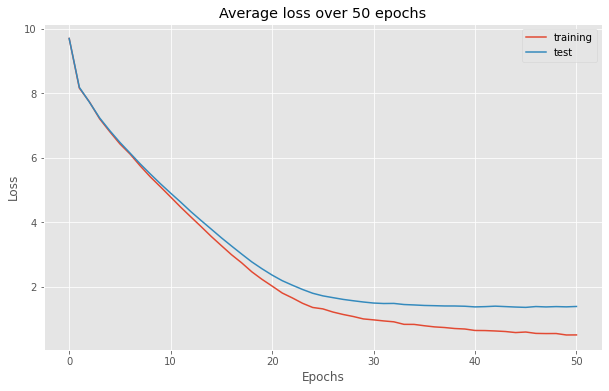


Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  3963600   
_________________________________________________________________
decoder (Decoder)            multiple                  17784204  
Total params: 21,747,804
Trainable params: 15,266,204
Non-trainable params: 6,481,600
_________________________________________________________________


In [ ]:
ae_training.trainModel(model=TwitterAE, word2vec_model=word2vec_model, train_dataset=train_dataset, test_dataset=test_dataset, loss_function=tf.keras.losses.SparseCategoricalCrossentropy(), num_epochs=50)
TwitterAE.save_weights(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/{Architecture}/Models/Model_Weights_AE/TwitterAE")

In [ ]:
TwitterAE.compile()
TwitterAE.load_weights(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/{Architecture}/Models/Model_Weights_AE/TwitterAE")

## **The LaTextGAN**

Create a dataset containing the embeddings of real tweets to train our Discriminator on.

In [ ]:
train_dataset_GAN = train_dataset_input

if Architecture == "Standard_LaTextGAN" or Architecture == "Bidirectional_LaTextGAN":
  train_dataset_GAN = train_dataset_GAN.map(lambda x: tf.squeeze(TwitterAE.Encoder(tf.expand_dims(x, axis=0))))

elif Architecture == "Stacked_LaTextGAN" or Architecture == "Bidirectional_Stacked_LaTextGAN":
  train_dataset_GAN = train_dataset_GAN.map(lambda x: TwitterAE.Encoder(tf.expand_dims(x, axis=0)))
  train_dataset_GAN = train_dataset_GAN.map(lambda x, y: (tf.squeeze(x), tf.squeeze(y)))

train_dataset_GAN = train_dataset_GAN.cache().batch(50).prefetch(tf.data.experimental.AUTOTUNE)

### Loss and Gradient Penalty for training

#### WGAN Loss

The Discriminator is exchanged with an approximator to the Wasserstein-distance, which tries to optimize: 
> $W(p_x, G(z)) = argmax _\theta \mathbb{E}_{x\text ~p_x} [D(x)] - \mathbb{E}_{x\text ~ G(x)}[D(x)]$




The generator then is trained by maximizing:

> $\mathbb{E}_{x\text ~ G(x)}[D(x)]$.




#### Gradient Penalty
Since enforcing a k-Lipschitz constraint via weight clipping biases the discriminator towards much simpler function the authors of the "Improved training of Wasserstein GANs" proposed a different way to enforce the Lipschitz constraint. 



"A differentiable function is 1-Lipschtiz if and only if it has gradients with norm at most 1 everywhere, so we consider directly constraining the gradient norm of the [... Discriminator] output with respect to its input. To circumvent
tractability issues, we enforce a soft version of the constraint with a penalty on the gradient norm
for random samples $\hat{\boldsymbol{x}} \sim \mathbb{P}_{\hat{\boldsymbol{x}}}$. Our new objective is" (Gulrajani, 2017):

$\begin{equation}
L=\underset{\tilde{\boldsymbol{x}} \sim \mathbb{P}_{g}}{\mathbb{E}}[D(\tilde{\boldsymbol{x}})]-\underset{\boldsymbol{x} \sim \mathbb{P}_{r}}{\mathbb{E}}[D(\boldsymbol{x})]+\lambda \underset{\hat{\boldsymbol{x}} \sim \mathbb{P}_{\hat{\boldsymbol{x}}}}{\mathbb{E}}\left[\left(\left\|\nabla_{\hat{\boldsymbol{x}}} D(\hat{\boldsymbol{x}})\right\|_{2}-1\right)^{2}\right]
\end{equation}$


We followed the authors approach and enforced the unit gradient norm only along straight lines that are uniformly sampled between pairs of points from the data and generator distribution. Furthermore, we set $\lambda$ to the recommended value of 10.

---


Source: Gulrajani, Ishaan, et al. "Improved training of wasserstein gans." arXiv preprint arXiv:1704.00028 (2017).

## **Import Model and Training modules for the LaTextGAN**

In [ ]:
if Architecture == "Standard_LaTextGAN" or Architecture == "Bidirectional_LaTextGAN":
  import standard_latextgan as latextgan
  import standard_latextgan_training as latextgan_training
elif Architecture == "Stacked_LaTextGAN" or Architecture == "Bidirectional_Stacked_LaTextGAN":
  import bidirectional_stacked_latextgan as latextgan
  import bidirectional_stacked_latextgan_training as latextgan_training

## **Run the Model or load previously saved Generator Weights**

Epoch: 150

This epoch took 27.8444 seconds

The current generator loss: 6.4937

The current discriminator loss: -2.0635


From Fixed Vector: some very important day for republicans on colorado should take their victory in london . #fakenews ! <End>
From Fixed Vector: it was announced from both states and good ending thank you under his past ! <End>

From Random Vector: some attacks with this press has made a commercial with their leaders , it needs me . <End>
From Random Vector: @oreillyfactor , thanks . i believe is right now ! <End>


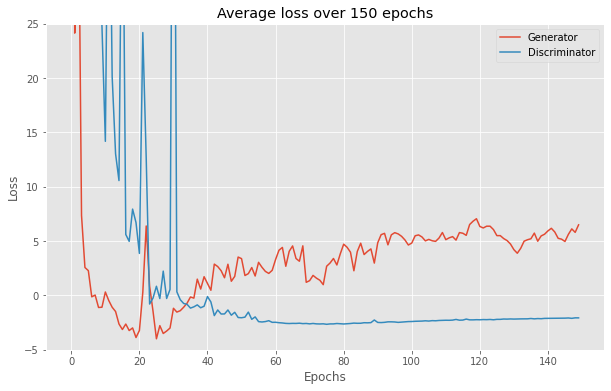

In [ ]:
LaTextGAN_Generator = latextgan.Generator()
LaTextGAN_Discriminator = latextgan.Discriminator()

latextgan_training.train_GAN(generator=LaTextGAN_Generator, discriminator=LaTextGAN_Discriminator, autoencoder=TwitterAE, word2vec_model=word2vec_model, train_dataset_GAN=train_dataset_GAN, num_epochs=150)
LaTextGAN_Generator.save_weights(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/{Architecture}/Models/Model_Weights_LaTextGAN/LaTextGAN")

In [ ]:
# Load Generator weights
LaTextGAN_Generator = latextgan.Generator()
LaTextGAN_Generator.compile()
LaTextGAN_Generator.load_weights(f"drive/MyDrive/Final_Project/{Preprocessing_Mode}/{Architecture}/Models/Model_Weights_LaTextGAN/LaTextGAN")

## **Import Evaluation module for the LaTextGAN**

In [ ]:
if Architecture == "Standard_LaTextGAN" or Architecture == "Bidirectional_LaTextGAN":
  import standard_latextgan_evaluation as eval  
elif Architecture == "Stacked_LaTextGAN" or Architecture == "Bidirectional_Stacked_LaTextGAN":
  import bidirectional_stacked_latextgan_evaluation as eval

## **Evaluate LaTextGAN**

### Use LaTextGAN to generate new Tweets


In [ ]:
eval.tweet_generator(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=word2vec_model, num_tweets=50)

Trump would tweet:

ted : good and ; eyes : go on the border wall , among your values , which has been fully brought to the <num> <num> killers / conservative and , legal citizens . thank you for your support ! <End>

its time did to thank you ! <End>

rt @kthopkins : im not reasonable in your life . weve been in office , but i am voting for the wall . youve got <num> hours for the <num> election , and you got your vote on the border . get rid of the good faith and , stop them ! <End>

some of fools people will put in a presidential primary because i have done a lot of people and , if they stayed in <num> . they are under pressure with a very important achievement ! <End>

see your pro from my pro of pro pro of your friends to address their nations during my speech : <End>

oh : your job by joe , who was quick out at all point of the border border . he has been saying a lot of people on earth numbers . if you get your vote , especially when it is the most important two days in office .

### Latent Space Analysis of Encoder and Generator using TSNE

In [ ]:
eval.bleu4_score(generator=LaTextGAN_Generator, autoencoder=TwitterAE, word2vec_model=word2vec_model, reference_data=train_data, num_tweets=500)

0.5234748932389259

In [ ]:
eval.latent_space_analysis(generator=LaTextGAN_Generator, autoencoder=TwitterAE, train_dataset=train_dataset, name=f"{Architecture}, {Preprocessing_Mode}")

Cumulative explained variation for enocder embedding: 0.9701459857617093
Cumulative explained variation for generator embedding: 0.9277846761586451
